In [1]:
import pandas as pd

In [1]:
'''

Goals:

1. For both sequence scenarios associated with the classical FS:
    - Check if the roc-auc score of BSFS + RF was not random; 
        confirming it was not random; 
        do permutation test to compare the roc-auc values
    - Check if BSFS + RF has a stastically significant result compared to the others using DeLong's Test
        
2. For both sequence scenarios associated with AE FS
    - Check if the roc-auc scores of AE + RF was not random
        confirming it was not random;
        do permutation test to compare the roc-auc values
        
3. Using DeLong's test check if AE FS v/s Classical FS significance



1. Permutation test of each model and compute the distance
2. DeLong's Test between models (per-sequence, merged-sequence & classical, auto-encoder)

write this in the result section. Put the results in the supplementary materials. dicuss more in the discussion session. 

'''

"\n\nGoals:\n\n1. For both sequence scenarios associated with the classical FS:\n    - Check if the roc-auc score of BSFS + RF was not random; \n        confirming it was not random; \n        do permutation test to compare the roc-auc values\n    - Check if BSFS + RF has a stastically significant result compared to the others using DeLong's Test\n        \n2. For both sequence scenarios associated with AE FS\n    - Check if the roc-auc scores of AE + RF was not random\n        confirming it was not random;\n        do permutation test to compare the roc-auc values\n        \n3. Using DeLong's test check if AE FS v/s Classical FS significance\n\n\n\n1. Permutation test of each model and compute the distance\n2. DeLong's Test between models (per-sequence, merged-sequence & classical, auto-encoder)\n\nwrite this in the result section. Put the results in the supplementary materials. dicuss more in the discussion session. \n\n"

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)#because of xgboost warnings

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [3]:
OUT_PATH = r"./results"

In [4]:
out_path = os.path.join(OUT_PATH,"comparisons")

if not os.path.exists(out_path):
    os.makedirs(out_path)

In [5]:
merged_df = pd.read_csv("merged_df.csv")

signatures = {}
signatures["sequence"] = pd.read_csv("./results/signatures_sequence.csv")
signatures["merged"] = pd.read_csv("./results/signatures_merged.csv")

In [27]:
custom_dict = {"sequence_AE_LogisticRegression":signatures['sequence']["AE_LogisticRegression"].to_list(),"merged_AE_LogisticRegression":signatures['merged']["AE_LogisticRegression"].to_list()}
out_path = r"C:\Sithin\autoencoder\for_Tiziana"
for file_name,feats in custom_dict.items():
    
    out_df = {}
    
    out_df["patient_id"] = merged_df["id"].to_list()
    out_df["label"] = merged_df["label"].to_list()
    
    for feat in feats:
        out_df[feat] = merged_df[feat].to_list()
        
        
    out_df = pd.DataFrame.from_dict(out_df)
    
    out_df.to_csv(os.path.join(out_path,f"{file_name}.csv"),index=False)

In [26]:
pd.DataFrame.from_dict(out_df)

,patient_id,label,t2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis,dce_wout_logarithm_glszm_LargeAreaLowGrayLevelEmphasis,dce_win_logarithm_ngtdm_Complexity,adc_exponential_glszm_LargeAreaLowGrayLevelEmphasis
0,2417361,0,2.178707e+06,0.094699,39738.947381,12139.316739
1,2535039,1,1.289043e+06,0.640567,4689.103091,2883.298490
2,2602563,1,1.265574e+07,0.917717,11699.867609,5719.126292
3,2902440,0,1.474015e+06,0.001027,15052.974970,14403.906735
4,2921898,0,4.123004e+05,1.800528,23534.446604,25547.692547
...,...,...,...,...,...,...
95,3908895,0,3.673237e+05,0.003283,256793.823928,24126.404787
96,3911843,0,8.884492e+05,0.010934,39134.398343,13926.624800
97,9534972,0,1.131802e+05,0.001408,134926.286864,18812.622331
98,9803775,0,7.294561e+05,1.318452,25023.159505,53006.310098


In [13]:
signatures['sequence']["AE_LogisticRegression"].to_list()

['t2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis',
 'dce_wout_logarithm_glszm_LargeAreaLowGrayLevelEmphasis',
 'dce_win_logarithm_ngtdm_Complexity',
 'adc_exponential_glszm_LargeAreaLowGrayLevelEmphasis']

In [12]:
signatures['merged']["AE_LogisticRegression"]

0    adc_exponential_glszm_LargeAreaLowGrayLevelEmp...
1                   dce_win_logarithm_ngtdm_Complexity
2    t2w_logarithm_glszm_LargeAreaHighGrayLevelEmph...
3                 adc_exponential_glszm_ZonePercentage
Name: AE_LogisticRegression, dtype: object

In [7]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=0)

estimators = {
    "BSFS":{LogisticRegression(penalty='none'),SVC(probability=True),RandomForestClassifier()},
    "AE":{LogisticRegression(penalty='none'),SVC(probability=True),RandomForestClassifier()}
}

# DeLong's Test

In [8]:
from compare_auc_delong_xu import delong_roc_test

In [9]:
def get_delongsP(estimator1_spec, estimator2_spec, merged_df, signatures, cv):
    
    estimator1 = estimator1_spec["estimator"]
    estimator1_fs = estimator1_spec["fs_type"]
    estimator1_dim = estimator1_spec["dimension"]
    
    estimator2 = estimator2_spec["estimator"]
    estimator2_fs = estimator2_spec["fs_type"]
    estimator2_dim = estimator2_spec["dimension"]
    
    p_values = []
    
    signature1 = signatures[estimator1_dim][estimator1_fs+"_"+estimator1.__class__.__name__] 
    signature2 = signatures[estimator2_dim][estimator2_fs+"_"+estimator2.__class__.__name__] 
    
    X1 = merged_df[signature1].to_numpy()
    X2 = merged_df[signature2].to_numpy()
    
    y = merged_df["label"].to_numpy().ravel()
    
    estimator1_pipeline = make_pipeline(StandardScaler(),estimator1)
    estimator2_pipeline = make_pipeline(StandardScaler(),estimator2)

    
    for train_idx, val_idx in cv.split(X1,y):
        
        estimator1_pipeline.fit(X1[train_idx],y[train_idx])
        pred1 = estimator1_pipeline.predict_proba(X1[val_idx])[:,1]
        
        estimator2_pipeline.fit(X2[train_idx],y[train_idx])
        pred2 = estimator2_pipeline.predict_proba(X2[val_idx])[:,1]
        
        gt = y[val_idx]
        
        p = np.power(10,delong_roc_test(gt, pred1, pred2))
        
        p_values.append(p)
        
        
        
    return p_values
    

In [10]:
model_tags = {
    "LogisticRegression":"LR",
    "SVC":"SVC",
    "RandomForestClassifier":"RFC"
}

# Comparison - Per Sequence - Classical Model v/s AE Model

In [11]:
delongs_df = {"classical_FS":[],"autoencoder_FS":[],"p_value":[]}
for estimator1 in estimators["BSFS"]:
    
    estimator1_spec = {"estimator":estimator1, "fs_type":"BSFS","dimension":"sequence"}
    
    for estimator2 in estimators["AE"]:
        
        estimator2_spec = {"estimator":estimator2, "fs_type":"AE","dimension":"sequence"}
        
        p_values = get_delongsP(estimator1_spec, estimator2_spec, merged_df, signatures,rskf)
        
        delongs_df["classical_FS"] += [model_tags[estimator1.__class__.__name__]]*len(p_values)
        delongs_df["autoencoder_FS"] += [model_tags[estimator2.__class__.__name__]]*len(p_values)
        delongs_df["p_value"] += list(np.array(p_values).ravel())


In [12]:
df = pd.DataFrame.from_dict(delongs_df)

In [13]:
df.to_csv("sequence_CLvsAE.csv",index=False)

In [14]:
df.to_csv(os.path.join(out_path,"sequence_CLvsAE.csv"),index=False)

In [15]:
df = pd.read_csv(os.path.join(out_path,"sequence_CLvsAE.csv"))

In [16]:
import matplotlib.pyplot as plt

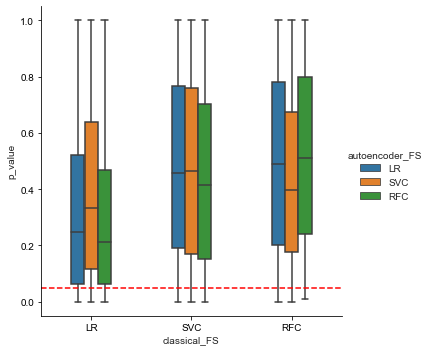

In [17]:
sns.set_style('white')
#sns.set_context('paper', font_scale=1)
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})


hue_order = ["LR","SVC","RFC"]
g= sns.catplot(x="classical_FS",y="p_value",hue="autoencoder_FS",data=df, kind="box", order=hue_order, hue_order=hue_order, width=0.4,legend=True)


g.axes[0][0].axhline(0.05, ls='--',color="red")
#sns.despine(offset=2, trim=True)


# Comparison - Merged Sequence - Classical v/s AE Models

In [18]:
delongs_df = {"classical_FS":[],"autoencoder_FS":[],"p_value":[]}
for estimator1 in estimators["BSFS"]:
    
    estimator1_spec = {"estimator":estimator1, "fs_type":"BSFS","dimension":"merged"}
    
    for estimator2 in estimators["AE"]:
        
        estimator2_spec = {"estimator":estimator2, "fs_type":"AE","dimension":"merged"}
        
        p_values = get_delongsP(estimator1_spec, estimator2_spec, merged_df, signatures,rskf)
        
        delongs_df["classical_FS"] += [model_tags[estimator1.__class__.__name__]]*len(p_values)
        delongs_df["autoencoder_FS"] += [model_tags[estimator2.__class__.__name__]]*len(p_values)
        delongs_df["p_value"] += list(np.array(p_values).ravel())


In [19]:
df = pd.DataFrame.from_dict(delongs_df)

In [20]:
df.to_csv("merged_CLvsAE.csv",index=False)

In [21]:
df.to_csv(os.path.join(out_path,"merged_CLvsAE.csv"),index=False)

In [22]:
df = pd.read_csv(os.path.join(out_path,"merged_CLvsAE.csv"))

In [23]:
import matplotlib.pyplot as plt

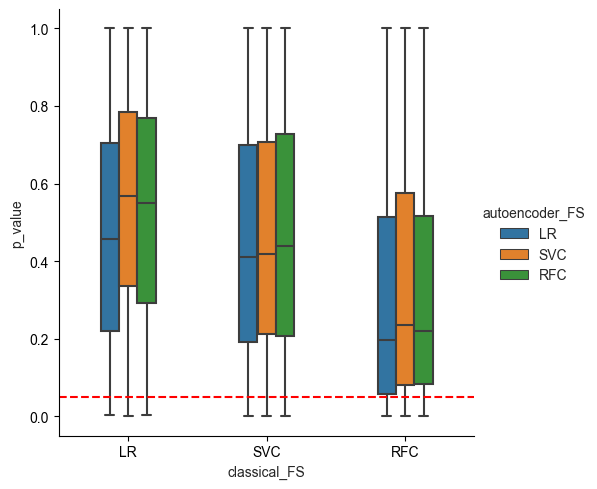

In [24]:
sns.set_style('white')
#sns.set_context('paper', font_scale=1)
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})


hue_order = ["LR","SVC","RFC"]
g= sns.catplot(x="classical_FS",y="p_value",hue="autoencoder_FS",data=df, order=hue_order, hue_order=hue_order, kind="box", width=0.4,legend=True)


g.axes[0][0].axhline(0.05, ls='--',color="red")
#sns.despine(offset=2, trim=True)


In [25]:
# sns.set_style('white')
# #sns.set_context('paper', font_scale=1)
# sns.set_style('ticks', {'axes.edgecolor': '0',  
#                         'xtick.color': '0',
#                         'ytick.color': '0'})


# g = sns.catplot(x="p_value",y="classical_FS",hue="autoencoder_FS",data=df, kind="box", width=0.4,legend=True)
# g.axes[0][0].axvline(0.05, ls='--',color="red")
# #sns.despine(offset=5, trim=True)


# Comparison - Merged v/s PerSequence

In [26]:
delongs_df = {"estimator":[],"fs_type":[],"p_value":[]}
for estimator in estimators["AE"]:
    
    for fs_type in ["AE","BSFS"]:
    
        estimator1_spec = {"estimator":estimator, "fs_type":fs_type,"dimension":"sequence"}
        estimator2_spec = {"estimator":estimator, "fs_type":fs_type,"dimension":"merged"}

        p_values = get_delongsP(estimator1_spec, estimator2_spec, merged_df, signatures,rskf)

        delongs_df["estimator"] += [model_tags[estimator.__class__.__name__]]*len(p_values)
        delongs_df["fs_type"] += [fs_type]*len(p_values)
        delongs_df["p_value"] += list(np.array(p_values).ravel())

        
    

In [27]:
df = pd.DataFrame.from_dict(delongs_df)

In [28]:
df.to_csv(os.path.join(out_path,"mergedVSsequence.csv"),index=False)

In [29]:
df = pd.read_csv(os.path.join(out_path,"mergedVSsequence.csv"))

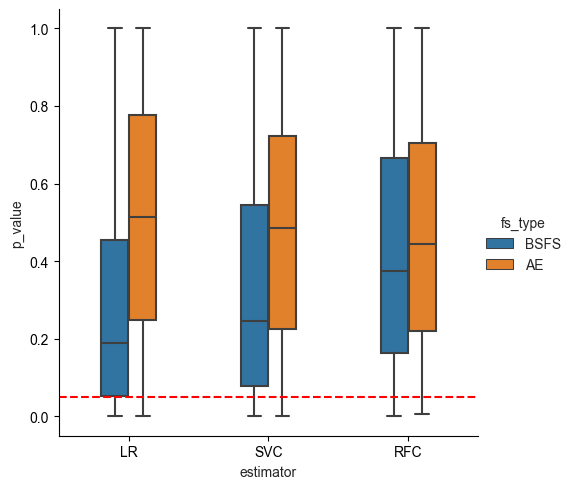

In [32]:
sns.set_style('white')
#sns.set_context('paper', font_scale=1)
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})


g= sns.catplot(x="estimator",y="p_value",hue="fs_type",data=df, kind="box", order=["LR", "SVC", "RFC"], hue_order=["BSFS","AE"], width=0.4,legend=True)
g.axes[0][0].axhline(0.05, ls='--',color="red")

# Comparion BSFS_PerSequence v/s BSFS_MergedSequence

In [ ]:
pairs = list(product([i for i in list(estimators.keys()) if "sequence_BSFS" in i],[j for j in list(estimators.keys()) if "merged_BSFS" in j]))

In [ ]:
delongP_df = {"BSFS-PS":[],"BSFS-MS":[],"p-value":[]}

In [ ]:
sequence_acronym = {"sequence":"PS","merged":"MS"}
estimator_acronym = {"LogisticRegression":"LR","SVC":"SVC","RandomForestClassifier":"RFC"}

In [ ]:
delong_df2 = pd.DataFrame.from_dict(delongP_df)

In [ ]:
delong_df2 = pd.DataFrame.from_dict(delongP_df)

#### 1. Merged Sequence

#### 2. Per Sequence

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import permutation_test_score

## Permutation Test

In [ ]:
OUT_PATH=r"./results"
FEAT_PATH = r"./features_StudySettings3D.csv"

In [ ]:
feat_df = pd.read_csv(FEAT_PATH)

In [ ]:
def get_data(features):
    
    
    
    

In [ ]:
feat_df = pd.read_csv(FEAT_PATH)

features = []

merged_df = {}

for sequence,feats in selected_feats.items():### 9. Compute Delta based on mean
    
    for feat in feats:
        features.append(sequence+"_"+feat)
        merged_df[sequence+"_"+feat] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])[feat].values

merged_df["label"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["label"].values
merged_df["id"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["id"].values
    
merged_df = pd.DataFrame.from_dict(merged_df)

In [ ]:
from compare_auc_delong_xu import delong_roc_test

In [ ]:
ground_truth, predictions_one, predictions_two

In [ ]:
import numpy as np

In [ ]:
ground_truth = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1])

predictions_one = np.array([0.1,0.2,0.05,0.3,0.1,0.6,0.6,0.7,0.8,0.99,0.8,0.67,0.5])

predictions_two = np.array([0.3,0.6,0.2,0.1,0.1,0.9,0.23,0.7,0.9,0.4,0.77,0.3,0.89])

In [ ]:
np.vstack([ground_truth, predictions_one, predictions_two])

In [ ]:
np.power(10,delong_roc_test(ground_truth, predictions_one, predictions_two))

In [ ]:
#Logistic Regression

estimator = LogisticRegression(penalty="none")

RADIOMICS_SIGNATURE_MERGED = ['t2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis', 'dce_win_logarithm_firstorder_Energy', 'dce_wout_logarithm_glszm_SizeZoneNonUniformity', 'adc_exponential_glszm_LargeAreaEmphasis']

estimator_pipeline = make_pipeline(StandardScaler(), estimator)
results = permutation_test_score(estimator_pipeline, X, y, scoring=["roc_auc"],verbose=1,cv=rskf)





RADIOMICS_SIGNATURE_MERGED

